In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
import seaborn as sns
sns.set_style("dark")

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

from warnings import filterwarnings
filterwarnings('ignore')

%pylab inline
data=None
def absolute_correlations(col, df=data):
    #absolute_values = np.abs(df[col])
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs.sort_values('absol', ascending=False).drop('absol', axis=1).tail(len(corrs)-1)

Populating the interactive namespace from numpy and matplotlib


In [38]:
data = pd.read_csv('data_cleaned.csv')
data = data[[i for i in data.columns if 'Unnamed' not in i]]

# Use only good data

# Users could enter any number for age, so let's remove the jokers
data = data[data['age'] < 71]
data.replace(-1, np.nan, inplace=True)
data = data.dropna()

# Simplify genders down to two, for convenience
data = data[(data['gender'] < 3) & (data['gender'] > 0)]
data['gender'] = np.where(data['gender'] == 1, 'man', 'woman')

# These two items were most strongly correlated.
# Let's remove respondents who didn't answer them similarly.
data['reliable'] = np.where(
    np.abs(data['I have frequent mood swings.'] - data['I change my mood a lot.']) > 2, 0, 1)

data = data[data.reliable == 1]
del data['reliable']

data.shape

(19011, 53)

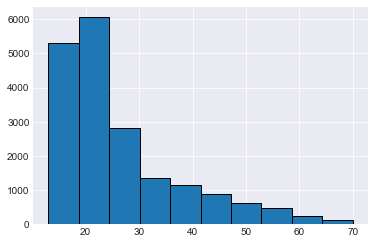

In [39]:
data['age'].hist(edgecolor='black')

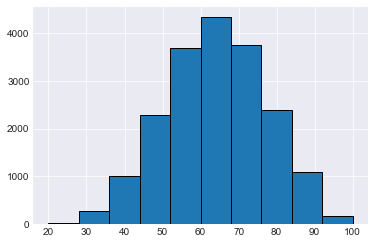

In [40]:
data['Conscientiousness'] =\
(data['I am always prepared.'] +
data['I get chores done right away.'] +
data['I like order.'] +
data['I follow a schedule.'] +
data['I am exacting in my work.'] +
(6 - data['I leave my belongings around.']) +
(6 - data['I pay attention to details.']) +
(6 - data['I make a mess of things.']) +
(6 - data['I often forget to put things back in their proper place.']) +
(6 - data['I shirk my duties.']))/.5

data['Conscientiousness'].hist(edgecolor='black')

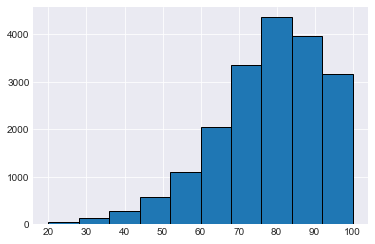

In [41]:
data['Agreeableness'] =\
(data['I take time out for others.'] +
data['I am interested in people.'] +
data["I sympathize with others' feelings."] +
data['I have a soft heart.'] +
data['I make people feel at ease.'] +
data["I feel others' emotions."] +
(6 - data["I am not interested in other people\'s problems."]) +
(6 - data["I insult people."]) +
(6 - data["I feel little concern for others."]) +
(6 - data['I am not really interested in others.']))/.5

data['Agreeableness'].hist(edgecolor='black')

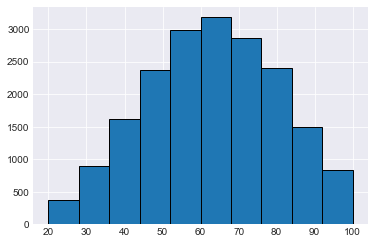

In [42]:
data['Neuroticism'] =\
(data['I get stressed out easily.'] +
data['I worry about things.'] +
data['I am easily disturbed.'] +
data['I get upset easily.'] +
data['I change my mood a lot.'] +
data['I have frequent mood swings.'] +
data['I get irritated easily.'] +
data['I often feel blue.'] +
(6 - data['I am relaxed most of the time.']) +
(6 - data['I seldom feel blue.']))/.5

data['Neuroticism'].hist(edgecolor='black')

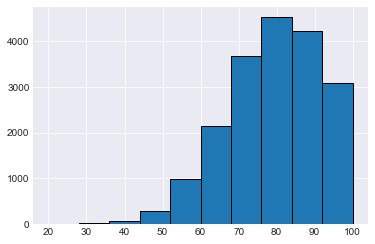

In [43]:
data['Openness'] =\
(data['I have a rich vocabulary.'] +
data['I have a vivid imagination.'] +
data['I have excellent ideas.'] +
data['I am quick to understand things.'] +
data['I use difficult words.'] +
data['I spend time reflecting on things.'] +
data['I am full of ideas.'] +
(6 - data['I have difficulty understanding abstract ideas.']) +
(6 - data['I do not have a good imagination.']) +
(6 - data['I am not interested in abstract ideas.']))/.5

data['Openness'].hist(edgecolor='black')

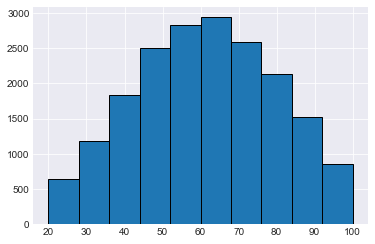

In [44]:
data['Extraversion'] =\
(data['I am the life of the party.'] +
data['I feel comfortable around people.'] +
data['I start conversations.'] +
data['I talk to a lot of different people at parties.'] +
data["I don't mind being the center of attention."] +
(6 - data["I don't like to draw attention to myself."]) +
(6 - data["I don't talk a lot."]) +
(6 - data["I have little to say."]) +
(6 - data['I am quiet around strangers.']) +
(6 - data['I keep in the background.']))/.5

data['Extraversion'].hist(edgecolor='black')

"Introvert" doesn't have a clear, agreed-upon definition in psychology. I typically just define it as someone who scores below the median in the trait of extraversion. But it's probably more accurate to say an introvert is someone whose average answer to the questions above is less than 3 (neutral).

How many people are introverts under that definition?

In [9]:
len(data[data.Extraversion < 50])/len(data)
# About 30%

0.28772815738256796

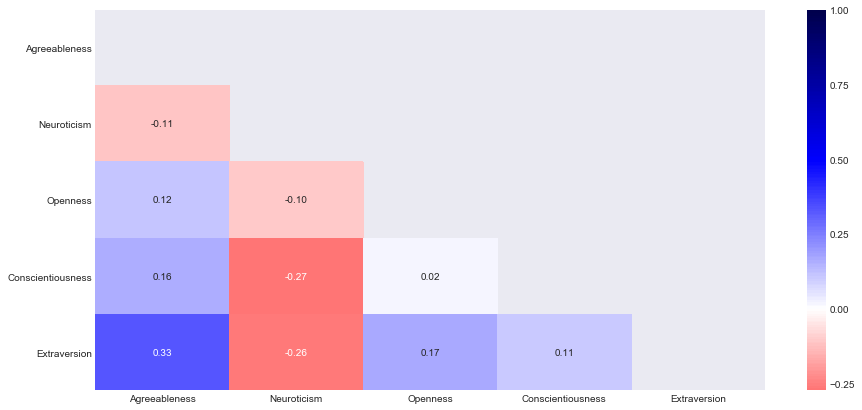

In [10]:
def correlation_matrix(df, figsize=(15,7)):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(df.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Resize and display
    plt.figure(figsize=figsize)
    sns.heatmap(df.corr(), annot=True, fmt='.2f', mask=mask, center=0, cmap='seismic_r')
    
traits = data[['Agreeableness', 'Neuroticism', 'Openness',
               'Conscientiousness', 'Extraversion']]

correlation_matrix(traits)

# Gender Differences

In [11]:
women = data[data.gender == 'woman']
men = data[data.gender == 'man']

traits = [
    'Agreeableness',
    'Neuroticism',
    'Openness',
    'Conscientiousness',
    'Extraversion'
]

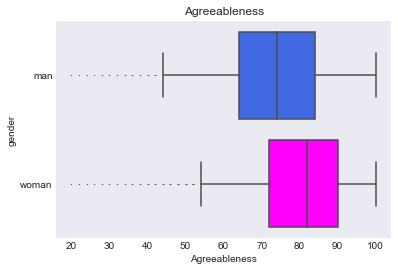

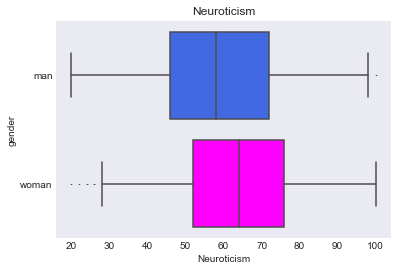

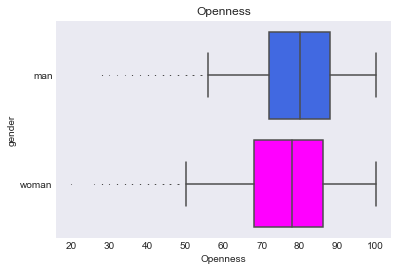

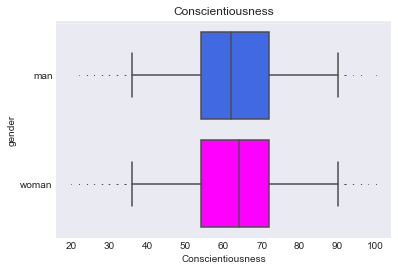

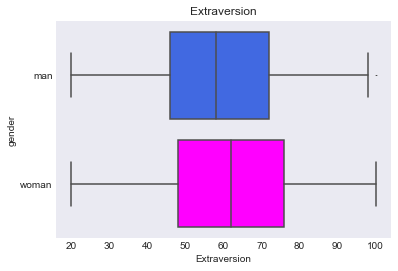

In [12]:
for trait in traits:
    sns.boxplot(y='gender', x=trait, data=data, fliersize=.2,
                palette=['royalblue', 'magenta'], saturation=1,
               whis=1)
    plt.title(trait)
    plt.show()

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

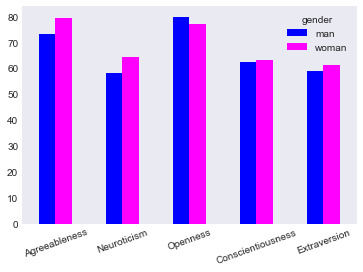

In [13]:
men_v_women = data.groupby('gender').mean()[traits].T

men_v_women.plot.bar(color=['blue', 'magenta'])

plt.xticks(rotation=20)

Men and women differ the most on agreeableness (which is the ability to empathize), and neuroticism (which is negative emotion). Let's graph those two.

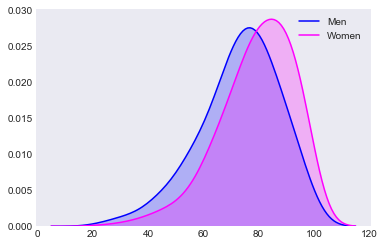

In [14]:
sns.kdeplot(men.Agreeableness, color='blue', shade=True, bw=5)
sns.kdeplot(women.Agreeableness, color='magenta', shade=True, bw=5)
plt.legend(['Men', 'Women'])

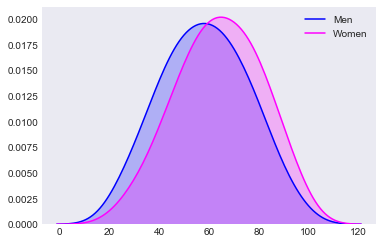

In [15]:
sns.kdeplot(men.Neuroticism, color='blue', shade=True, bw=7)
sns.kdeplot(women.Neuroticism, color='magenta', shade=True, bw=7)
plt.legend(['Men', 'Women'])

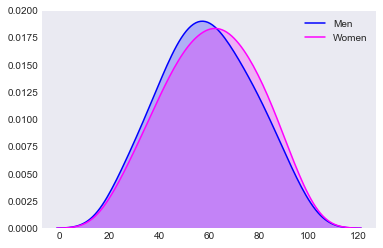

In [16]:
sns.kdeplot(men.Extraversion, color='blue', shade=True, bw=7)
sns.kdeplot(women.Extraversion, color='magenta', shade=True, bw=7)
plt.legend(['Men', 'Women'])

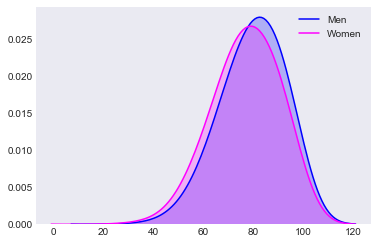

In [17]:
sns.kdeplot(men.Openness, color='blue', shade=True, bw=7)
sns.kdeplot(women.Openness, color='magenta', shade=True, bw=7)
plt.legend(['Men', 'Women'])

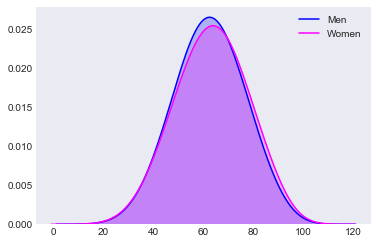

In [18]:
sns.kdeplot(men.Conscientiousness, color='blue', shade=True, bw=7)
sns.kdeplot(women.Conscientiousness, color='magenta', shade=True, bw=7)
plt.legend(['Men', 'Women'])

# Personality over time

In [19]:
bins = np.arange(data.age.min()+1, data.age.max()+1, 10)
data['age_group'] = pd.Series(pd.cut(data['age'], bins=bins))

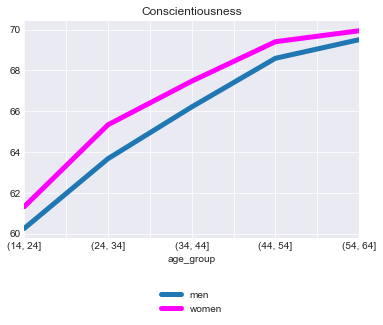

In [20]:
men_c = data[data['gender'] == 'man'].groupby('age_group').mean()
women_c = data[data['gender'] == 'woman'].groupby('age_group').mean()

men_c['Conscientiousness'].plot(linewidth=5, grid=True, label='men')
women_c['Conscientiousness'].plot(linewidth=5, color='magenta', grid=True, label='women')

plt.title('Conscientiousness')

pylab.legend(loc=9, bbox_to_anchor=(0.5, -.2))

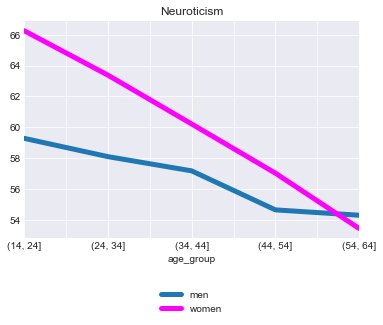

In [21]:
men_n = data[data['gender'] == 'man'].groupby('age_group').mean()
women_n = data[data['gender'] == 'woman'].groupby('age_group').mean()

men_n['Neuroticism'].plot(linewidth=5, grid=True, label='men')
women_n['Neuroticism'].plot(linewidth=5, color='magenta', grid=True, label='women')

plt.title('Neuroticism')
pylab.legend(loc=9, bbox_to_anchor=(0.5, -.2))

Sadly, I think there's survivorship bias when measuring neuroticism. People with poor mental health are not going to live as long. Nonetheless, our mental health seems to improve as we get older (as many formerly anxious teens will tell you).

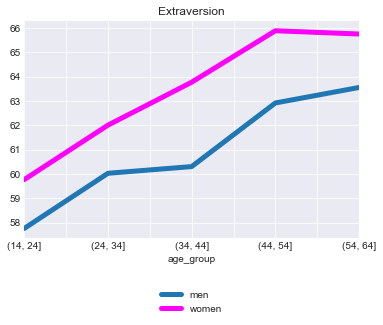

In [22]:
men_e = data[data['gender'] == 'man'].groupby('age_group').mean()
women_e = data[data['gender'] == 'woman'].groupby('age_group').mean()

men_e['Extraversion'].plot(linewidth=5, grid=True, label='men')
women_e['Extraversion'].plot(linewidth=5, color='magenta', grid=True, label='women')

plt.title('Extraversion')

pylab.legend(loc=9, bbox_to_anchor=(0.5, -.2))

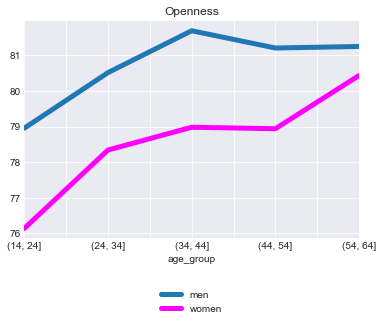

In [23]:
men_o = data[data['gender'] == 'man'].groupby('age_group').mean()
women_o = data[data['gender'] == 'woman'].groupby('age_group').mean()

men_o['Openness'].plot(linewidth=5, grid=True, label='men')
women_o['Openness'].plot(linewidth=5, color='magenta', grid=True, label='women')

plt.title('Openness')

pylab.legend(loc=9, bbox_to_anchor=(0.5, -.2))

I think there's some selection bias here. It would make a lot more sense if openness (which measures curiosity) declined over time. But the fact that it increases leads me to believe that intellectually curious old folks are more likely to take a personality test.

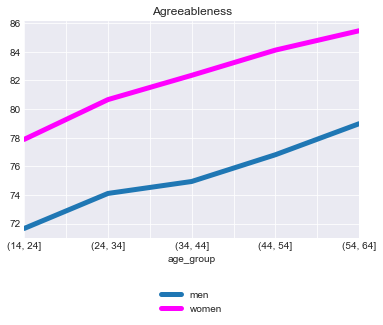

In [24]:
men_a = data[data['gender'] == 'man'].groupby('age_group').mean()
women_a = data[data['gender'] == 'woman'].groupby('age_group').mean()

men_a['Agreeableness'].plot(linewidth=5, grid=True, label='men')
women_a['Agreeableness'].plot(linewidth=5, color='magenta', grid=True, label='women')

plt.title('Agreeableness')
plt.legend(['Men', 'Women'])
pylab.legend(loc=9, bbox_to_anchor=(0.5, -.2))

# Personality by country

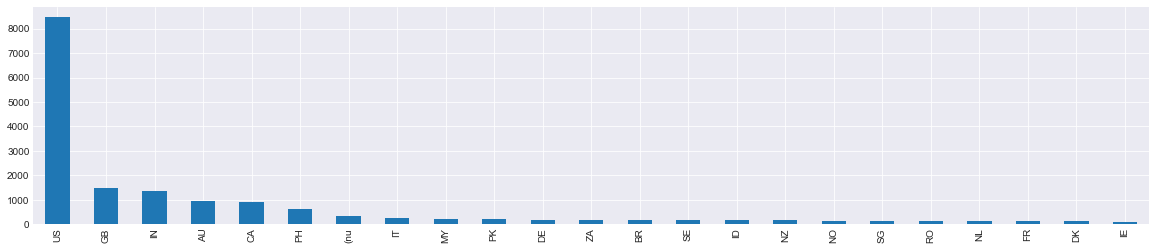

In [25]:
countries = data.country.value_counts()
countries[countries > 99].plot.bar(figsize=(20,4), grid=True)

In [26]:
top_countries = countries[countries > 99].drop('(nu').index
men = data[data.gender == 'man']
women = data[data.gender == 'woman']

### Agreeableness

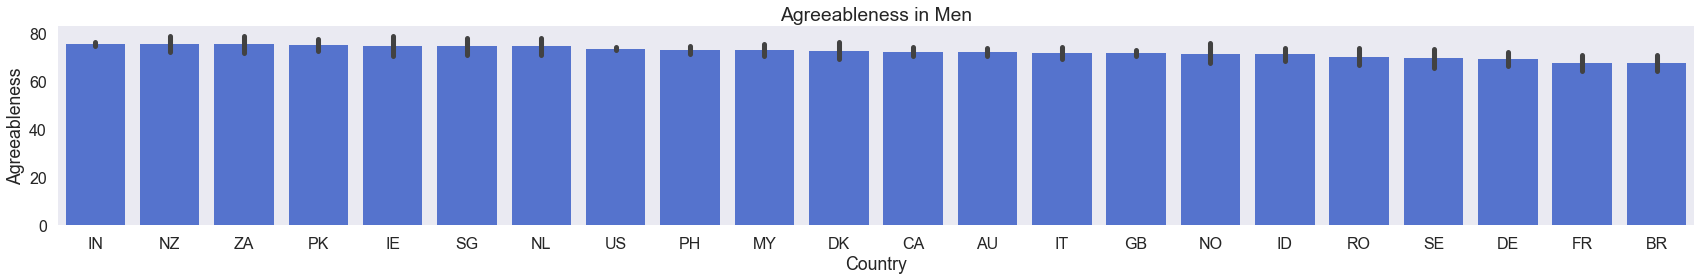

In [27]:
sns.set_context('poster')

# This sorts the countries by average male agreeableness
men_a =\
men[men.country.isin(top_countries)].groupby('country').mean()['Agreeableness']\
.sort_values(ascending=False).index

sns.factorplot('country', 'Agreeableness', data=men[men.country.isin(top_countries)]\
               .sort_values('Agreeableness', ascending=False),
               kind='bar', order=men_a,
               palette=['royalblue'], size=4, aspect=6)\
.set(xlabel='Country', ylabel='Agreeableness')

plt.title('Agreeableness in Men')

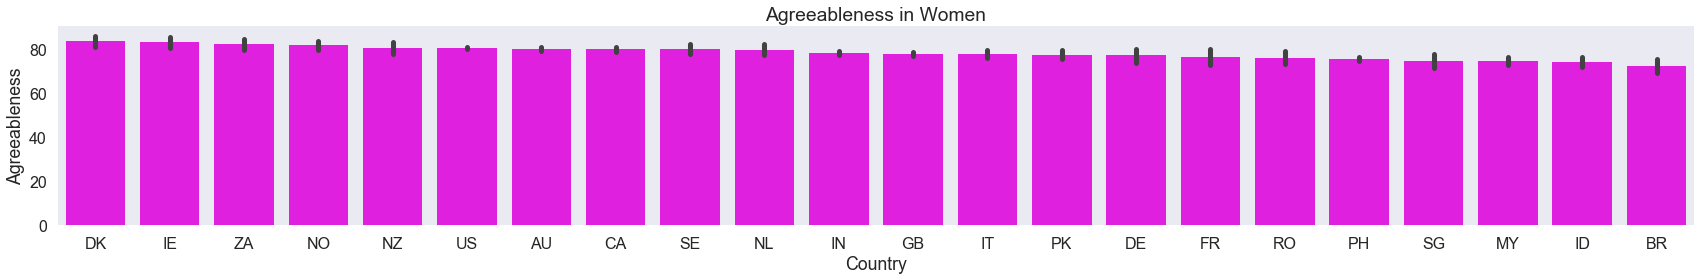

In [28]:
sns.set_context('poster')

# This sorts the countries by average female agreeableness
women_a =\
women[women.country.isin(top_countries)].groupby('country').mean()['Agreeableness']\
.sort_values(ascending=False).index

sns.factorplot('country', 'Agreeableness', data=women[women.country.isin(top_countries)]\
               .sort_values('Agreeableness', ascending=False),
               kind='bar', order=women_a,
               palette=['magenta'], size=4, aspect=6)\
.set(xlabel='Country', ylabel='Agreeableness')

plt.title('Agreeableness in Women')

### Neuroticism

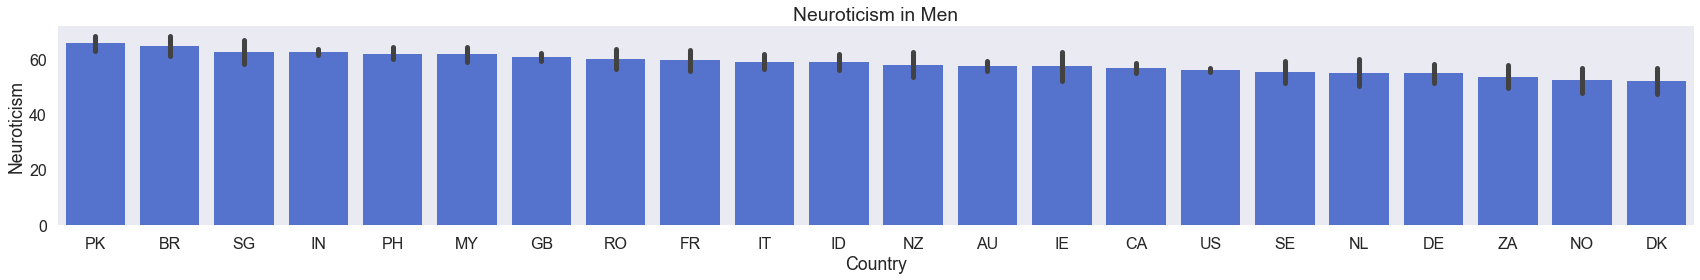

In [29]:
men_n =\
men[men.country.isin(top_countries)].groupby('country').mean()['Neuroticism']\
.sort_values(ascending=False).index

sns.factorplot('country', 'Neuroticism', data=men[men.country.isin(top_countries)]\
               .sort_values('Neuroticism', ascending=False),
               kind='bar', order=men_n,
               palette=['royalblue'], size=4, aspect=6)\
.set(xlabel='Country', ylabel='Neuroticism')

plt.title('Neuroticism in Men')

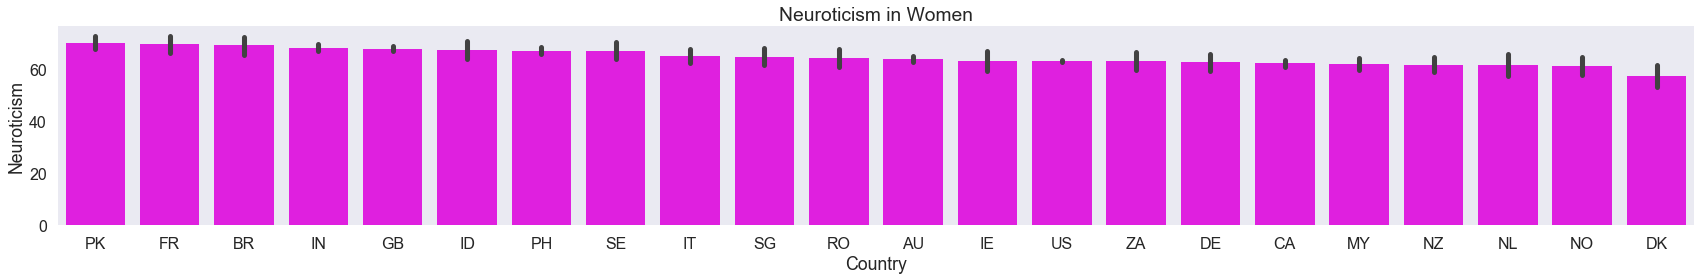

In [30]:
women_n =\
women[women.country.isin(top_countries)].groupby('country').mean()['Neuroticism']\
.sort_values(ascending=False).index

sns.factorplot('country', 'Neuroticism', data=women[women.country.isin(top_countries)]\
               .sort_values('Neuroticism', ascending=False),
               kind='bar', order=women_n,
               palette=['magenta'], size=4, aspect=6)\
.set(xlabel='Country', ylabel='Neuroticism')

plt.title('Neuroticism in Women')

### Extraversion

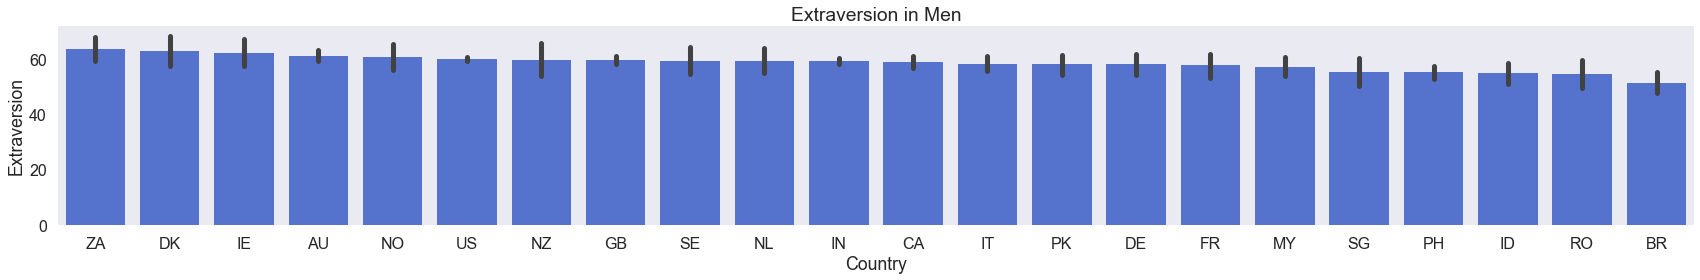

In [31]:
men_e =\
men[men.country.isin(top_countries)].groupby('country').mean()['Extraversion']\
.sort_values(ascending=False).index

sns.factorplot('country', 'Extraversion', data=men[men.country.isin(top_countries)]\
               .sort_values('Extraversion', ascending=False),
               kind='bar', order=men_e,
               palette=['royalblue'], size=4, aspect=6)\
.set(xlabel='Country', ylabel='Extraversion')

plt.title('Extraversion in Men')

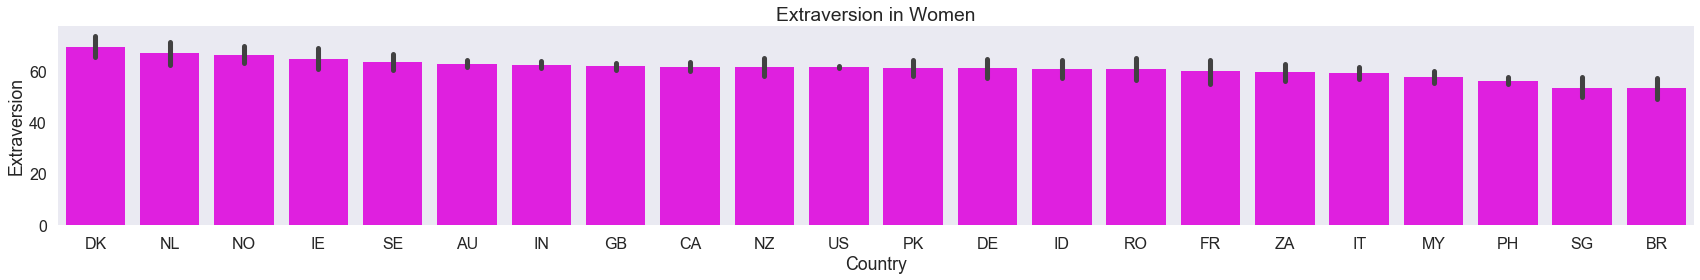

In [32]:
women_e =\
women[women.country.isin(top_countries)].groupby('country').mean()['Extraversion']\
.sort_values(ascending=False).index

sns.factorplot('country', 'Extraversion', data=women[women.country.isin(top_countries)]\
               .sort_values('Extraversion', ascending=False),
               kind='bar', order=women_e,
               palette=['magenta'], size=4, aspect=6)\
.set(xlabel='Country', ylabel='Extraversion')

plt.title('Extraversion in Women')

### Conscientiousness

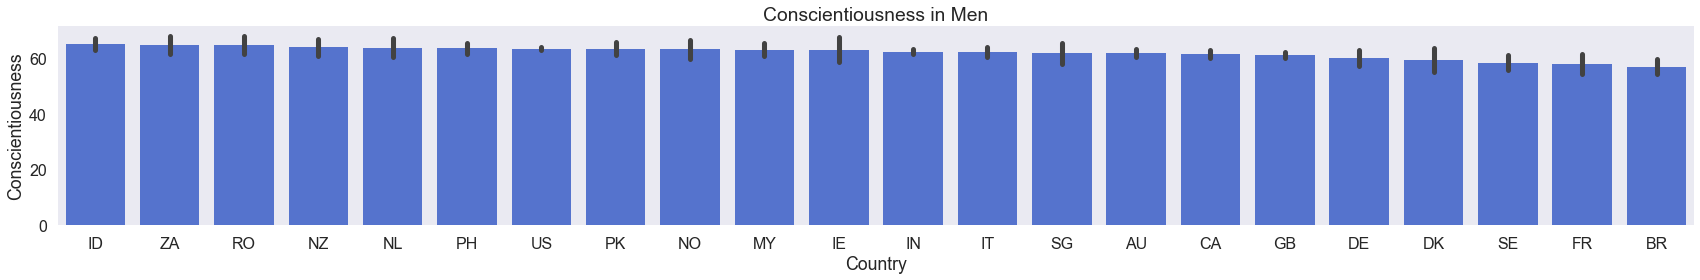

In [33]:
men_c =\
men[men.country.isin(top_countries)].groupby('country').mean()['Conscientiousness']\
.sort_values(ascending=False).index

sns.factorplot('country', 'Conscientiousness', data=men[men.country.isin(top_countries)]\
               .sort_values('Conscientiousness', ascending=False),
               kind='bar', order=men_c,
               palette=['royalblue'], size=4, aspect=6)\
.set(xlabel='Country', ylabel='Conscientiousness')

plt.title('Conscientiousness in Men')

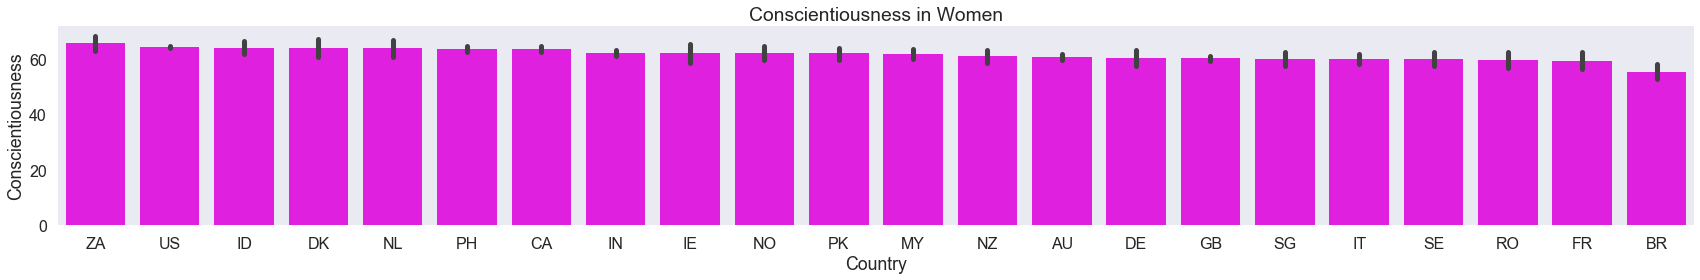

In [34]:
women_c =\
women[women.country.isin(top_countries)].groupby('country').mean()['Conscientiousness']\
.sort_values(ascending=False).index

sns.factorplot('country', 'Conscientiousness', data=women[women.country.isin(top_countries)]\
               .sort_values('Conscientiousness', ascending=False),
               kind='bar', order=women_c,
               palette=['magenta'], size=4, aspect=6)\
.set(xlabel='Country', ylabel='Conscientiousness')

plt.title('Conscientiousness in Women')

### Openness

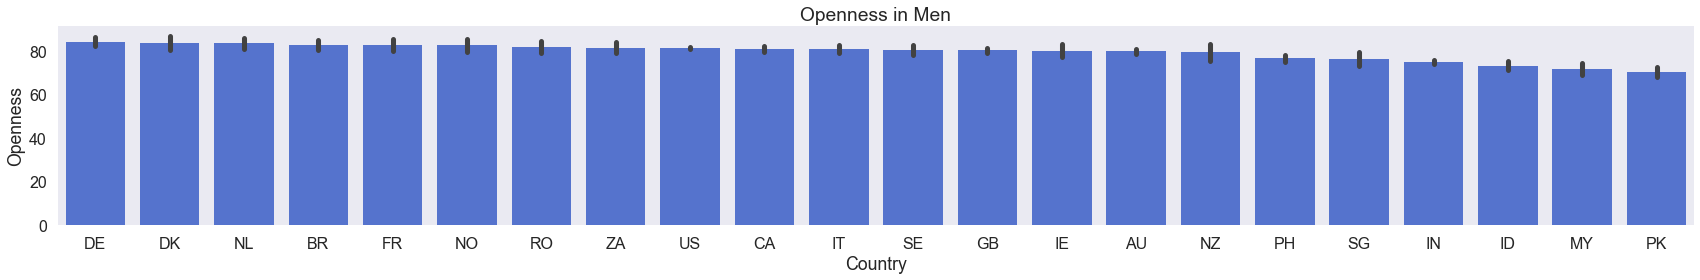

In [35]:
men_o =\
men[men.country.isin(top_countries)].groupby('country').mean()['Openness']\
.sort_values(ascending=False).index

sns.factorplot('country', 'Openness', data=men[men.country.isin(top_countries)]\
               .sort_values('Openness', ascending=False),
               kind='bar', order=men_o,
               palette=['royalblue'], size=4, aspect=6)\
.set(xlabel='Country', ylabel='Openness')

plt.title('Openness in Men')

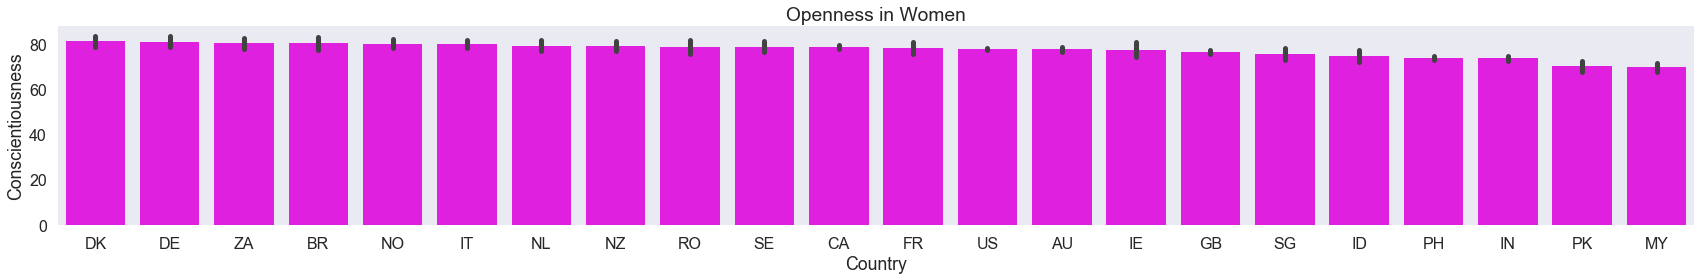

In [36]:
women_o =\
women[women.country.isin(top_countries)].groupby('country').mean()['Openness']\
.sort_values(ascending=False).index

sns.factorplot('country', 'Openness', data=women[women.country.isin(top_countries)]\
               .sort_values('Openness', ascending=False),
               kind='bar', order=women_o,
               palette=['magenta'], size=4, aspect=6)\
.set(xlabel='Country', ylabel='Conscientiousness')

plt.title('Openness in Women')

# Factor analysis

In [45]:
# Save the personality and trait features so we can analyze them separately.
personality_items = data.drop('age', axis=1).select_dtypes(include=[np.number]).columns
traits = 'Openness Conscientiousness Extraversion Agreeableness Neuroticism'.split()

data_p = data[personality_items]
data_t = data[traits]

In [24]:
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis(n_components=10).fit(data_p)
fa1 = fa.transform(data_p)

# Stick it in a dataframe
factors = pd.DataFrame(fa.components_, columns=data_p.columns).T

for i in factors.columns:
    factors['absol'] = abs(factors[i])
    factors_sorted = factors.sort_values('absol', ascending=False).head(4) # Top 4
    print(i+1, factors_sorted['absol'].min())                              # Min value
    del factors['absol']

1 0.7791281078725075
2 0.6298456411745381
3 0.483352726568548
4 0.42818680208922333
5 0.6413421925521577
6 0.3442806551938966
7 0.2751294208843026
8 0.27369070537176565
9 0.19671265795687903
10 0.1873529934265861


There are definitely 5 factors here, just as we'd expect.

# Unsupervised Learning

"How many kinds of people are there?"

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for i in range(2,8):
    cl = KMeans(n_clusters=i, random_state=42).fit(data_p)
    print(i, silhouette_score(data_p, cl.labels_))

2 0.10520389402959085
3 0.07627676856106134
4 0.06596613389175696
5 0.061222054759024105
6 0.05811191739692118
7 0.053104844571966375


KeyboardInterrupt: 

In [69]:
cl = KMeans(n_clusters=2, random_state=42).fit(data_p)
data_t['Type'] = cl.labels_ + 1

In [70]:
diff = data_t.groupby('Type').mean().T

diff['difference'] = abs(diff[1]-diff[2])/diff[1]

In [71]:
diff.sort_values('difference', ascending=False)

Type,1,2,difference
cluster,1.000000,2.000000,1.000000
Extraversion,73.500524,46.939436,0.361373
Neuroticism,53.429110,70.543283,0.320316
Agreeableness,82.704921,71.043864,0.140996
Conscientiousness,66.344293,59.605116,0.101579
Openness,80.638743,75.730472,0.060867


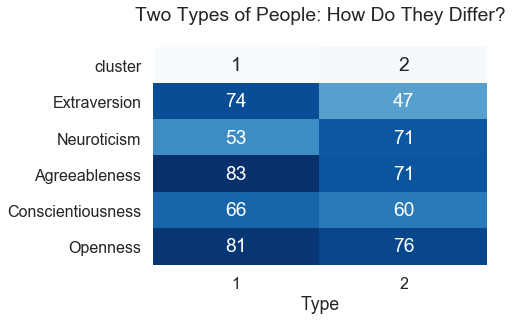

In [72]:
sns.set_context('poster')

sns.heatmap(diff.sort_values('difference', ascending=False).drop('difference', axis=1),
           annot=True, cmap='Blues', cbar=False)
plt.title('Two Types of People: How Do They Differ?\n')

The biggest difference is in extraversion, followed by neuroticism. This would suggest that the main way people tend to differ is in their overall happiness levels: extraversion predicts happiness, while neuroticism predicts depression.

If you go a step further and also take agreeableness into account, then you could say that there are people-persons, and those who a bit more solitary.

But I think there's something even more interesting to point out:

Notice that as you compare Type 1 people to Type 2 people, Type 1's tend to score on the more favorable end for each of the big five personality traits. So if you want to paint with a *really* broad brush, you could say there are people with "good" personalities, and people with not-so-good personalities. (I'm hesitant to call them "bad".)

There's hypothesis that there is a [general factor of personality](https://www.psychologytoday.com/blog/unique-everybody-else/201211/personalitys-big-one-reality-or-artifact); a "big one" rather than a "big five." This data would support that idea. A healthy, well-functioning brain would perform healthy behaviors in a variety of contexts. These are the Type 1's we see above one.

As you consider each of the big five, you'll almost certainly agree that:

- It's good to be agreeable.
- It's good to be conscientious.
- It's not good to be neurotic.

And you'll probably agree that:

- It's good to be extraverted.
- It's good to be open to experience.

But those last two are more controversial. Extraverts certainly aren't better people just because they're extraverted. But they do tend to be happier, and society tends to reward extraverted behavior. So I'm not making a value judgment, but I do think it's fair to say that it's good to be an extravert.

Openness to experience has a similar dilemma. Openness predicts liberal political opinions, and I'd have a much harder time convincing everyone that openness is always good (i.e., conservatives would disagree with me). So, by that token, it's interesting that openness is the *least* influential factor in distinguishing Type 1 and Type 2 people. But I should also point out that openness predicts intelligence, so I could still make a strong argument that it's "better" to be high in openness.

In any case, the consistency of the clusters across each of the big five is fascinating.